<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#kraken2-vs-nt" data-toc-modified-id="kraken2-vs-nt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>kraken2 vs nt</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Job-submission" data-toc-modified-id="Job-submission-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Job submission</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#kraken2-vs-vertebrata" data-toc-modified-id="kraken2-vs-vertebrata-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>kraken2 vs vertebrata</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Job-submission" data-toc-modified-id="Job-submission-6.0.1"><span class="toc-item-num">6.0.1&nbsp;&nbsp;</span>Job submission</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#kraken2-vs-plant" data-toc-modified-id="kraken2-vs-plant-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>kraken2 vs plant</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Job-submission" data-toc-modified-id="Job-submission-7.0.1"><span class="toc-item-num">7.0.1&nbsp;&nbsp;</span>Job submission</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Which-to-re-sequence?" data-toc-modified-id="Which-to-re-sequence?-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Which to re-sequence?</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

Given the low % reads mapped to many samples (for both kraken2 & humann2), I'm checking on whether there still may be some host (or other eukaryote DNA) in the post-QC metagenome samples. This analysis givens an upper bound for how many Eukaryotic reads may still be in each sample

* Using kraken2 with "loose" cutoff

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk/'

postqc_dir = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC'
postqc_read_files = file.path(postqc_dir, 'final', 'samples.txt')
samples_file = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/samples_cov-gte0.3.tsv'
metadata_file = '/ebio/abt3_projects/Georg_animal_feces/data/mapping/unified_metadata_complete_190529.tsv'

conda_env = 'Bracken2'
threads = 8

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(data.table)

library(future)
library(future.batchtools)
library(future.apply)
options(future.wait.interval = 2.0)

source('/ebio/abt3_projects/Georg_animal_feces/code/misc_r_functions/init.R')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘future.apply’

The following object is masked from ‘package:future’:

    future_lapply



In [8]:
make_dir(work_dir)

Created directory: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk/ 


In [61]:
# function for creating bash commands
create_cmds = function(X, db, outdir, threads=1){
    outfile = file.path(outdir, paste0(as.character(X['Sample']), '.kreport'))
    outL = file.path(outdir, paste0(as.character(X['Sample']), '.log'))
    cmd = 'mkdir -p {outdir}; kraken2 --threads {threads} --report {outfile} --output - --paired --db {db} {read1} {read2} 2> {logfile} 1>&2'
    cmd = glue::glue(cmd, outfile=outfile, 
                     confidence=confidence, threads=threads, 
                     db=db, 
                     read1=as.character(X['Read1']),
                     read2=as.character(X['Read2']),
                     logfile=outL)
    return(cmd)
}

In [62]:
#' function to parse kraken2 logs
parse_log = function(log_file){
    x = strsplit(as.character(read.delim(log_file)[2,]), ' ')[[1]]
    n_seq_filt = as.numeric(x[3])
    perc_seq_filt = as.numeric(gsub('[(]([0-9.]+).*', '\\1', x[6]))
    sample = basename(dirname(log_file))
    return(c(sample, n_seq_filt, perc_seq_filt))
}

# Load

In [16]:
metadata = read.delim(metadata_file, sep='\t') %>%
    dplyr::select(SampleID, class, order, family, genus, scientific_name, diet, habitat)
metadata %>% dfhead

[1] 475   8


SampleID,class,order,family,genus,scientific_name,diet,habitat
F14_Common_Bream,Actinopterygii,Cypriniformes,Cyprinidae,Abramis,Abramis_brama,omnivore,aquatic habitat
F35_Red_Deer,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,terrestrial habitat
F36_Red_Deer,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,terrestrial habitat


In [17]:
# postQC reads
postqc_reads = read.delim(postqc_read_files, sep='\t')
postqc_reads %>% dfhead

[1] 324   4


Sample,Read1,Read2,Notes
X101_Horse,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R1_final.fq.gz,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R2_final.fq.gz,NA
X107_House_Mouse,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R1_final.fq.gz,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R2_final.fq.gz,NA
X108_Striped_Desert_Hamster,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X108_Striped_Desert_Hamster/R1_final.fq.gz,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X108_Striped_Desert_Hamster/R2_final.fq.gz,NA


In [ ]:
# QC pipeline results
qc_dir = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/LLMGQC/'
F = file.path(qc_dir, 'reports/multiqc-final/multiqc_data/multiqc_fastqc.txt')
df_qc = read.delim(F, sep='\t') %>%
    mutate(Read = gsub('.+\\| ', '', Sample),
           Read = gsub('_final', '', Read),
           Sample = gsub(' *\\|.+', '', Sample))
df_qc %>% dfhead

# kraken2 vs nt

In [145]:
# job resources
resources = list(h_rt = '00:59:00',
                 h_vmem = '20G',
                 threads = threads,
                 conda.env = 'py3_physeq')     # conda env with batchtools installed
plan(batchtools_sge, resources=resources, workers=20)

In [146]:
# params
db_dir = '/ebio/abt3_projects/databases_no-backup/kraken2/nt_db'
out_dir = file.path(work_dir, 'nt')
make_dir(out_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt 


In [147]:
# creating jobs commands (1 per sample)
cmds = apply(postqc_reads, 1, create_cmds, 
             db=db_dir, outdir=out_dir, 
             threads=threads)
cmds %>% length
cmds[1:2]

[1] 324

[1] "mkdir -p /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt; kraken2 --threads 8 --report /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt/X101_Horse.kreport --output - --paired --db /ebio/abt3_projects/databases_no-backup/kraken2/nt_db /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R1_final.fq.gz /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R2_final.fq.gz 2> /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt/X101_Horse.log 1>&2"                        
[2] "mkdir -p /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt; kraken2 --threads 8 --report /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt/X107_House_Mouse.kreport --output - --paired --db /ebio/abt3_projects/databases_no-backup/kraken2/nt_db /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R1_final.fq.gz /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R2_final.fq.gz 2> /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt/X107_House_Mouse.log 1>&2"

### Job submission

In [148]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[1:10]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 10

In [150]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[11:100]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 90

In [153]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[101:150]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 50

In [154]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[151:200]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 50

In [156]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[201:250]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 50

In [157]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[251:300]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 50

In [158]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[301:324]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 24

In [160]:
#send_email('http://127.0.0.1:9705/notebooks/notebooks/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/03a_kraken2_vs_non-microbe.ipynb')

## Summary

In [161]:
F = list.files(out_dir, "*.kreport", recursive=TRUE, full.names=TRUE)
F %>% length %>% print
F %>% head(n=3)

[1] 324


[1] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt/unassigned.kreport"        
[2] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt/X1_Eurasian_Beaver.kreport"
[3] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//nt/X10_House_Mouse.kreport"

In [186]:
# reading in kreports
read_table = function(x){
    y = fread(x, sep='\t', header=FALSE) %>%
        filter(V4 %in% c('U', 'R', 'R1', 'D'))
    y$Sample = gsub('\\.kreport$', '', basename(x))
    return(y)
}

kreports = list()
kreports = F %>% as.list %>%
  lapply(read_table) %>%
  do.call(rbind, .) 
         
kreports %>% dfhead

[1] 2907    7


V1,V2,V3,V4,V5,V6,Sample
54.97,38208212,38208212,U,0,unclassified,unassigned
45.02,31289344,428875,R,1,root,unassigned
43.44,30193162,261150,R1,131567,cellular organisms,unassigned


In [218]:
# adding metadata
setdiff(kreports$Sample, metadata$SampleID %>% gsub('^F', 'XF', .)) %>% length

kreports = kreports %>%
    left_join(metadata %>% mutate(SampleID = gsub('^F', 'XF', SampleID)),
              c('Sample'='SampleID'))

kreports %>% dfhead

[1] 1

[1] 2907   14


V1,V2,V3,V4,V5,V6,Sample,class,order,family,genus,scientific_name,diet,habitat
54.97,38208212,38208212,U,0,unclassified,unassigned,NA,NA,NA,NA,NA,NA,NA
45.02,31289344,428875,R,1,root,unassigned,NA,NA,NA,NA,NA,NA,NA
43.44,30193162,261150,R1,131567,cellular organisms,unassigned,NA,NA,NA,NA,NA,NA,NA


In [219]:
# summarizing
kreports_s = kreports %>%
    mutate(V6 = gsub('^ +', '', V6)) %>%
    filter(V4 %in% c('D', 'U'))

kreports_s %>% dfhead

[1] 1620   14


V1,V2,V3,V4,V5,V6,Sample,class,order,family,genus,scientific_name,diet,habitat
54.97,38208212,38208212,U,0,unclassified,unassigned,NA,NA,NA,NA,NA,NA,NA
23.58,16387190,378448,D,2,Bacteria,unassigned,NA,NA,NA,NA,NA,NA,NA
19.27,13391496,92207,D,2759,Eukaryota,unassigned,NA,NA,NA,NA,NA,NA,NA


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.07   10.51   12.50   21.32   31.20   95.84 


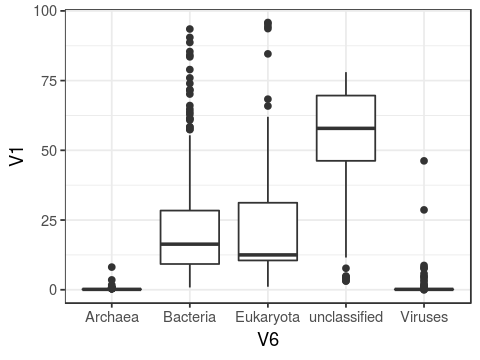

In [220]:
# plotting
kreports_s %>% filter(V6 == 'Eukaryota') %>% .$V1 %>% summary %>% print

p = kreports_s %>%
    ggplot(aes(V6, V1)) +
    geom_boxplot() +
    theme_bw()

dims(4, 3)
plot(p)

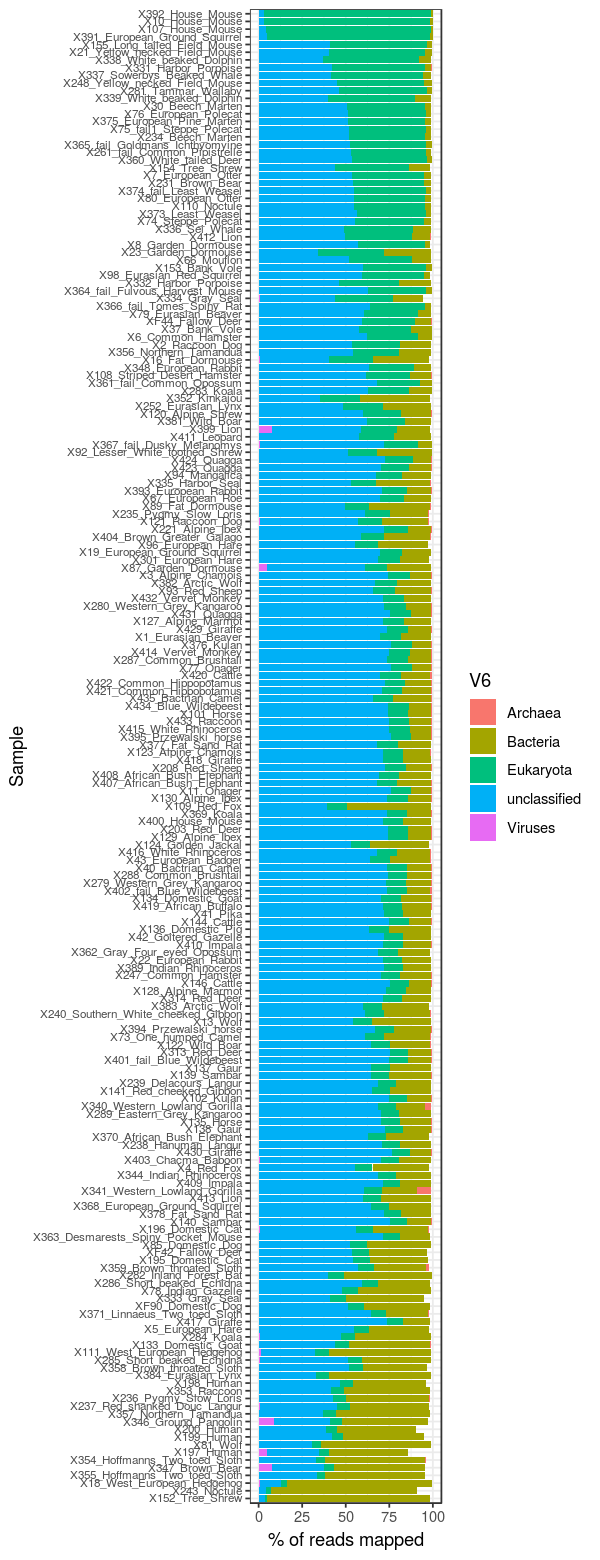

In [228]:
# bar plot
X = kreports_s %>%
    dplyr::select(Sample, V6, V1) %>%
    filter(V6 == 'Eukaryota') %>%
    rename('Euk_abund' = V1) %>%
    dplyr::select(-V6)

p = kreports_s %>%
    filter(class == 'Mammalia') %>%
    left_join(X, c('Sample')) %>%
    mutate(Sample = Sample %>% reorder(Euk_abund)) %>%
    ggplot(aes(Sample, V1, fill=V6)) +
    geom_bar(stat='identity') +
    coord_flip() +
    labs(y='% of reads mapped') +
    theme_bw() +
    theme(
        axis.text.y = element_text(size=7)
    )
    
dims(5,13)
plot(p)

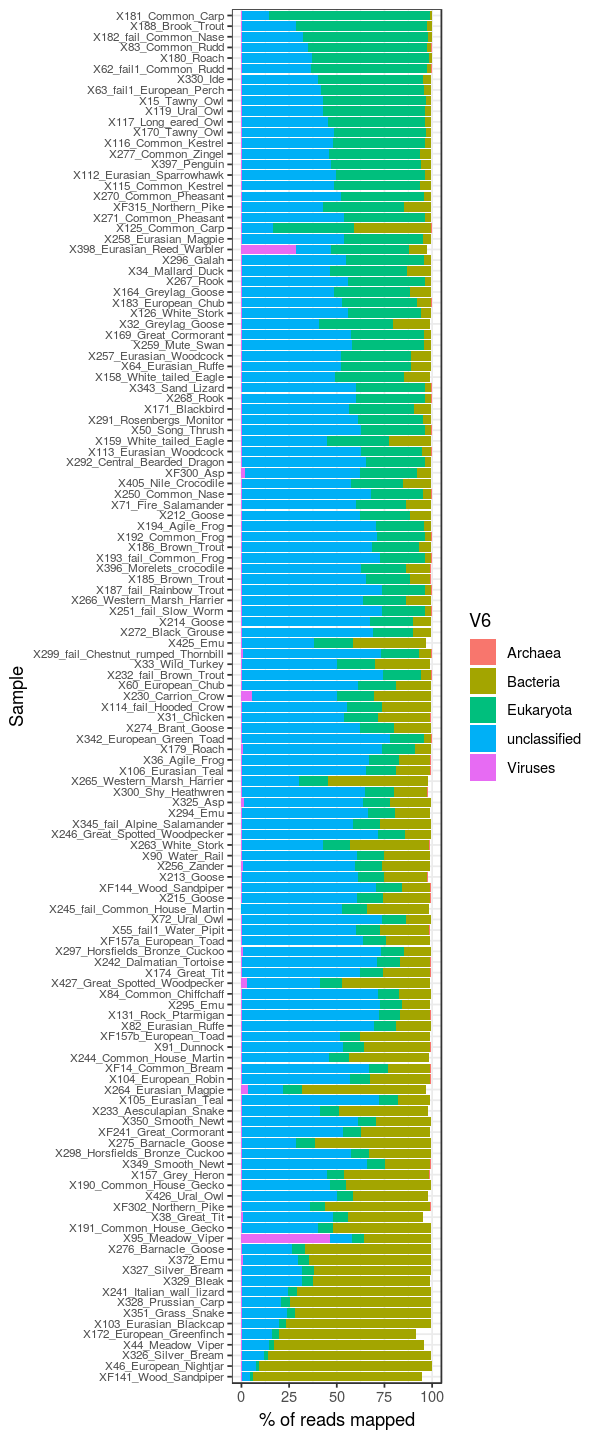

In [230]:
# bar plot
X = kreports_s %>%
    dplyr::select(Sample, V6, V1) %>%
    filter(V6 == 'Eukaryota') %>%
    rename('Euk_abund' = V1) %>%
    dplyr::select(-V6)

p = kreports_s %>%
    filter(class != 'Mammalia') %>%
    left_join(X, c('Sample')) %>%
    mutate(Sample = Sample %>% reorder(Euk_abund)) %>%
    ggplot(aes(Sample, V1, fill=V6)) +
    geom_bar(stat='identity') +
    labs(y='% of reads mapped') +
    coord_flip() +
    theme_bw() +
    theme(
        axis.text.y = element_text(size=7)
    )
    
dims(5,12)
plot(p)

# kraken2 vs vertebrata

In [83]:
# job resources
resources = list(h_rt = '00:59:00',
                 h_vmem = '10G',
                 threads = threads,
                 conda.env = 'py3_physeq')     # conda env with batchtools installed
plan(batchtools_sge, resources=resources, workers=20)

In [84]:
# params
db_dir = '/ebio/abt3_projects/databases_no-backup/kraken2/vertebrata-all_nt_db'
out_dir = file.path(work_dir, 'vertebrata-all_nt')
make_dir(out_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt 


In [85]:
# creating jobs commands (1 per sample)
cmds = apply(postqc_reads, 1, create_cmds, 
             db=db_dir, outdir=out_dir, 
             threads=threads)
cmds %>% length
cmds[1:2]

[1] 324

[1] "mkdir -p /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt; kraken2 --threads 8 --report /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt/X101_Horse.kreport --output - --paired --db /ebio/abt3_projects/databases_no-backup/kraken2/vertebrata-all_nt_db /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R1_final.fq.gz /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R2_final.fq.gz 2> /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt/X101_Horse.log 1>&2"                        
[2] "mkdir -p /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt; kraken2 --threads 8 --report /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt/X107_House_Mouse.kreport --output - --paired --db /ebio/abt3_projects/databases_no-backup/kraken2/vertebrata-all_nt_db /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R1_final.fq.gz /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R2_final.fq.gz 2> /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt/X107_House_Mouse.log 1>&2"

### Job submission

In [86]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[1:100]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 100

In [87]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[101:200]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 100

In [88]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[201:300]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 100

In [89]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[301:324]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 24

## Summary

In [90]:
F = list.files(out_dir, "*.kreport", recursive=TRUE, full.names=TRUE)
F %>% length %>% print
F %>% head(n=3)

[1] 324


[1] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt/unassigned.kreport"        
[2] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt/X1_Eurasian_Beaver.kreport"
[3] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//vertebrata-all_nt/X10_House_Mouse.kreport"

In [94]:
# reading in kreports
read_table = function(x){
    y = read.delim(x, sep='\t', nrows=40, header=FALSE)
    y$Sample = gsub('\\.kreport$', '', basename(x))
    return(y)
}

kreports = list()
kreports = F %>% as.list %>%
  lapply(read_table) %>%
  do.call(rbind, .) 
         
kreports %>% dfhead

[1] 12960     7


V1,V2,V3,V4,V5,V6,Sample
88.46,61480859,61480859,U,0,unclassified,unassigned
11.54,8022463,0,R,1,root,unassigned
11.54,8022463,0,R1,131567,cellular organisms,unassigned


In [95]:
# summarizing
kreports_s = kreports %>%
    mutate(V6 = gsub('^ +', '', V6)) %>%
    filter(V6 %in% c('unclassified', 'Eukaryota')) 

kreports_s %>% dfhead

[1] 648   7


V1,V2,V3,V4,V5,V6,Sample
88.46,61480859,61480859,U,0,unclassified,unassigned
11.54,8022463,0,D,2759,Eukaryota,unassigned
96.84,1566553,1566553,U,0,unclassified,X1_Eurasian_Beaver


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.930   3.100   5.125  14.195  23.163  95.370 


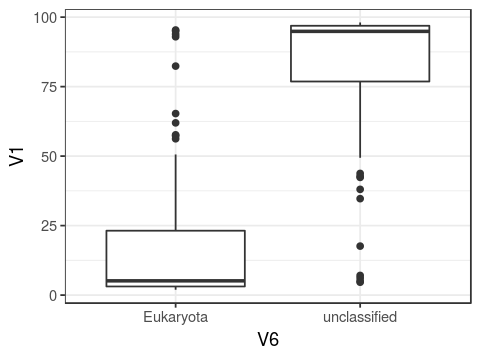

In [97]:
kreports_s %>% filter(V6 == 'Eukaryota') %>% .$V1 %>% summary %>% print

p = kreports_s %>%
    ggplot(aes(V6, V1)) +
    geom_boxplot() +
    theme_bw()

dims(4, 3)
plot(p)

In [100]:
# top samples
kreports_s %>%
    filter(V6 == 'Eukaryota') %>%
    arrange(-V1) %>%
    head(n=40)

V1,V2,V3,V4,V5,V6,Sample
95.37,10886505,0,D,2759,Eukaryota,X392_House_Mouse
94.96,4409690,0,D,2759,Eukaryota,X10_House_Mouse
93.86,2659335,0,D,2759,Eukaryota,X107_House_Mouse
92.93,506217,0,D,2759,Eukaryota,X391_European_Ground_Squirrel
82.38,814558,0,D,2759,Eukaryota,X181_Common_Carp
65.31,173029,0,D,2759,Eukaryota,X188_Brook_Trout
61.96,2036493,0,D,2759,Eukaryota,X182_fail_Common_Nase
57.66,1012576,0,D,2759,Eukaryota,X83_Common_Rudd
57.28,360383,0,D,2759,Eukaryota,X180_Roach
56.23,1290059,0,D,2759,Eukaryota,X62_fail1_Common_Rudd


# kraken2 vs plant

In [101]:
# job resources
resources = list(h_rt = '00:59:00',
                 h_vmem = '10G',
                 threads = threads,
                 conda.env = 'py3_physeq')     # conda env with batchtools installed
plan(batchtools_sge, resources=resources, workers=20)

In [102]:
# params
db_dir = '/ebio/abt3_projects/databases_no-backup/kraken2/plant_db'
out_dir = file.path(work_dir, 'plant_db')
make_dir(out_dir)

Created directory: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db 


In [103]:
# creating jobs commands (1 per sample)
cmds = apply(postqc_reads, 1, create_cmds, 
             db=db_dir, outdir=out_dir, 
             threads=threads)
cmds %>% length
cmds[1:2]

[1] 324

[1] "mkdir -p /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db; kraken2 --threads 8 --report /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db/X101_Horse.kreport --output - --paired --db /ebio/abt3_projects/databases_no-backup/kraken2/plant_db /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R1_final.fq.gz /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X101_Horse/R2_final.fq.gz 2> /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db/X101_Horse.log 1>&2"                        
[2] "mkdir -p /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db; kraken2 --threads 8 --report /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db/X107_House_Mouse.kreport --output - --paired --db /ebio/abt3_projects/databases_no-backup/kraken2/plant_db /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R1_final.fq.gz /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/LLMGQC/final/X107_House_Mouse/R2_final.fq.gz 2> /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db/X107_House_Mouse.log 1>&2"

### Job submission

In [104]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[1:100]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 100

In [105]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[101:200]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 100

In [106]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[201:300]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 100

In [107]:
# running jobs on the cluster
y = future_lapply(as.list(cmds[301:324]), FUN = function(x) bash_job(x, conda_env=conda_env))
y %>% length

[1] 24

## Summary

In [108]:
F = list.files(out_dir, "*.kreport", recursive=TRUE, full.names=TRUE)
F %>% length %>% print
F %>% head(n=3)

[1] 324


[1] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db/unassigned.kreport"        
[2] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db/X1_Eurasian_Beaver.kreport"
[3] "/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/kraken2_vs_euk//plant_db/X10_House_Mouse.kreport"

In [109]:
# reading in kreports
read_table = function(x){
    y = read.delim(x, sep='\t', nrows=40, header=FALSE)
    y$Sample = gsub('\\.kreport$', '', basename(x))
    return(y)
}

kreports = list()
kreports = F %>% as.list %>%
  lapply(read_table) %>%
  do.call(rbind, .) 
         
kreports %>% dfhead

[1] 12960     7


V1,V2,V3,V4,V5,V6,Sample
96.68,67198908,67198908,U,0,unclassified,unassigned
3.32,2304414,0,R,1,root,unassigned
3.32,2304414,0,R1,131567,cellular organisms,unassigned


In [110]:
# summarizing
kreports_s = kreports %>%
    mutate(V6 = gsub('^ +', '', V6)) %>%
    filter(V6 %in% c('unclassified', 'Eukaryota')) 

kreports_s %>% dfhead

[1] 648   7


V1,V2,V3,V4,V5,V6,Sample
96.68,67198908,67198908,U,0,unclassified,unassigned
3.32,2304414,282,D,2759,Eukaryota,unassigned
97.92,1583910,1583910,U,0,unclassified,X1_Eurasian_Beaver


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.110   1.972   2.665   3.756   4.197  24.690 


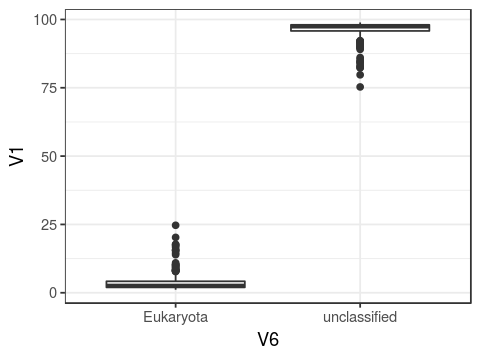

In [111]:
kreports_s %>% filter(V6 == 'Eukaryota') %>% .$V1 %>% summary %>% print

p = kreports_s %>%
    ggplot(aes(V6, V1)) +
    geom_boxplot() +
    theme_bw()

dims(4, 3)
plot(p)

In [112]:
# top samples
kreports_s %>%
    filter(V6 == 'Eukaryota') %>%
    arrange(-V1) %>%
    head(n=30)

V1,V2,V3,V4,V5,V6,Sample
24.69,529257,3,D,2759,Eukaryota,X328_Prussian_Carp
20.26,675718,9,D,2759,Eukaryota,X281_Tammar_Wallaby
17.71,819079,58,D,2759,Eukaryota,X398_Eurasian_Reed_Warbler
17.62,471115,15,D,2759,Eukaryota,X32_Greylag_Goose
17.20,20355,2,D,2759,Eukaryota,X330_Ide
16.62,564544,11,D,2759,Eukaryota,X212_Goose
15.67,211127,15,D,2759,Eukaryota,X34_Mallard_Duck
15.60,141346,1,D,2759,Eukaryota,X23_Garden_Dormouse
15.34,713670,11,D,2759,Eukaryota,X331_Harbor_Porpoise
14.51,160380,27,D,2759,Eukaryota,X164_Greylag_Goose


# Which to re-sequence?

# sessionInfo

In [3]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future.apply_1.0.0      future.batchtools_0.7.1 future_1.9.0           
 [4] data.table_1.11.4       doParallel_1.0.11       iterators_1.0.10       
 [7] foreach_1.4.4           ggp